In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


print()
print(np.__version__)
print(pd.__version__)
print(tf.__version__)


1.19.2
1.1.0
2.4.1


## Create Dataset

We will build the dataset from PHACs covid data.  We will use 2-dimensional (new_test_rate, new_case_rate) series of fixed length drawn from contiguous daily measurements as the input featues and fixed length death rates series chosen from the measurements immediately following the input series as the labels.



In [2]:
from src.phac import PHAC

can = PHAC()

x_input shape: (4370, 60, 2) y_labels shape: (4370, 30)


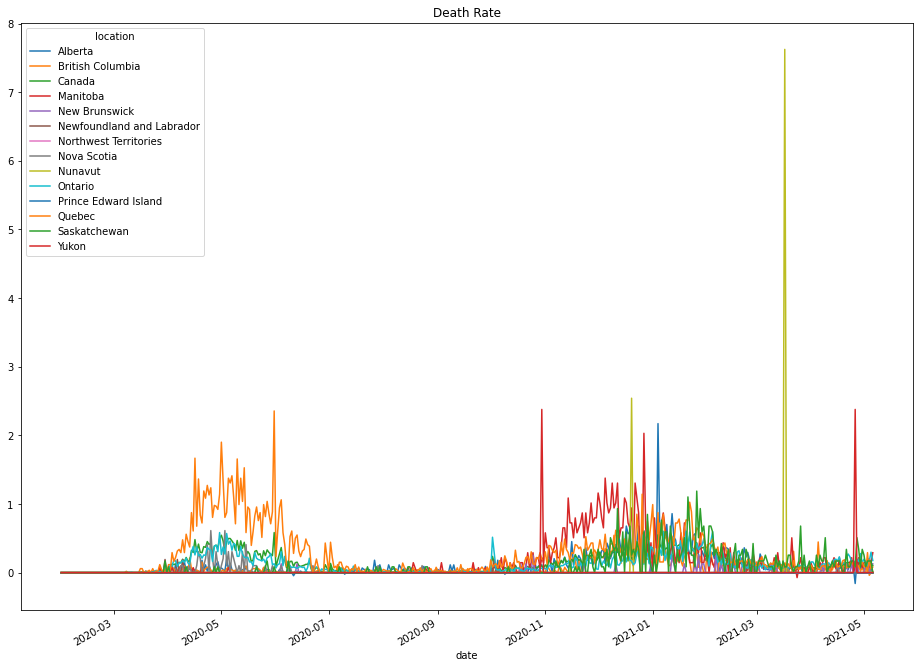

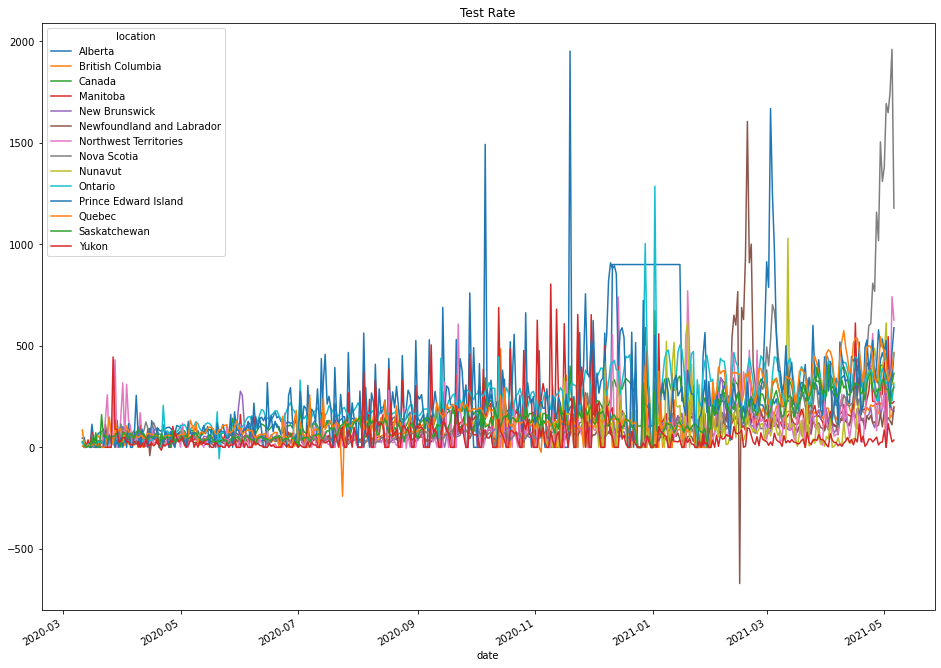

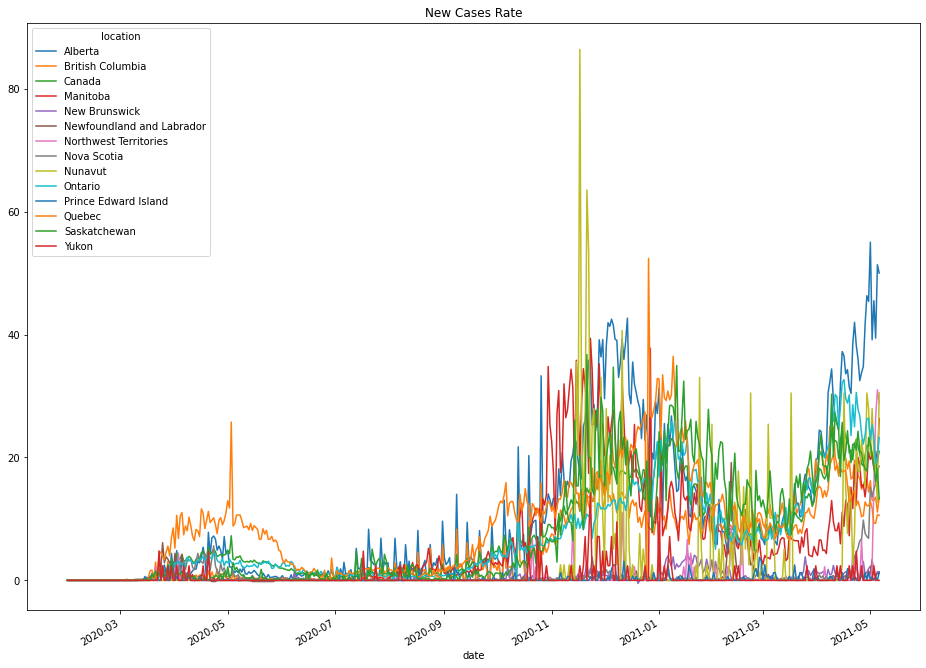

In [3]:
DEATHS_LAG = 30
INPUT_SEQ_LEN = 60

def valid_obs(seq):
    return all(map(lambda x: not np.isnan(x), seq))

def shuffle(a, b):
    perm = np.random.permutation(a.shape[0])
    return a[perm], b[perm]


tests = 100000 * can.var_by_location("new_tests_rate", *can.provinces, ma_window=1)
cases = 100000 * can.var_by_location("new_cases_rate", *can.provinces, ma_window=1).fillna(0.0)
deaths = 100000 * can.var_by_location("new_deaths_rate", *can.provinces, ma_window=1).fillna(0.0)

deaths.plot(figsize=(16,12), title="Death Rate")
tests.plot(figsize=(16,12), title="Test Rate")
cases.plot(figsize=(16,12), title="New Cases Rate")
# pt_rate = (cases / tests)
# pt_rate.replace([np.inf, -np.inf], np.nan, inplace=True)
# pt_rate.plot(figsize=(16,12), title="Positive Test Rate", ylim=(0,1.0))

# Build Data set
# x_input is sequences of [test_rate, case_rate] of length 60
# y_labels are length 30 of death_rate following the x-input

x_input = []
y_labels = []
locations = can.provinces

n_obs = min(len(tests), len(cases), len(deaths))

for k in range(n_obs - (DEATHS_LAG + INPUT_SEQ_LEN)):
    for loc in locations:
        loc_tests = tests[loc][k:k+INPUT_SEQ_LEN].values.tolist()
        loc_cases = cases[loc][k:k+INPUT_SEQ_LEN].values.tolist()
        loc_deaths = deaths[loc][k+INPUT_SEQ_LEN:k+INPUT_SEQ_LEN+DEATHS_LAG].values.tolist()
        if valid_obs(loc_tests):  # Exclude sequences with missing test data
            x_input.append(list(zip(loc_tests, loc_cases)))
            y_labels.append(loc_deaths)
            
x_input, y_labels = shuffle(np.array(x_input), np.array(y_labels))

print("x_input shape:", x_input.shape, "y_labels shape:", y_labels.shape)

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_input, y_labels, test_size=0.2)


## Simple Feedforward network 



In [38]:
# Define Model

HIDDEN_UNITS = 200

model_nn = keras.Sequential()

model_nn.add(layers.Flatten(input_shape=(INPUT_SEQ_LEN, 2)))

model_nn.add(layers.Dense(HIDDEN_UNITS, activation='relu', name='Hidden'))

model_nn.add(layers.Dense(DEATHS_LAG, activation='relu', name='Output'))

model_nn.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 120)               0         
_________________________________________________________________
Hidden (Dense)               (None, 200)               24200     
_________________________________________________________________
Output (Dense)               (None, 30)                6030      
Total params: 30,230
Trainable params: 30,230
Non-trainable params: 0
_________________________________________________________________


In [44]:
# Compile Model

mse = tf.keras.losses.MeanSquaredError()

mean_deaths = np.mean(y_labels, axis=0)

print(mean_deaths)
print(mse(y_labels, mean_deaths))



opt = keras.optimizers.Adam(learning_rate=0.01)
# opt = keras.optimizers.SGD(learning_rate=0.01)

model_nn.compile(
    loss=mse,
    optimizer=opt,
    metrics=['accuracy']
)



[0.08476578 0.08429243 0.08412275 0.0838869  0.08367884 0.0832476
 0.08304893 0.08284884 0.08276643 0.0828026  0.08275877 0.0826071
 0.08232876 0.08217684 0.08201411 0.08208471 0.08184194 0.08173465
 0.08164683 0.08147363 0.08182032 0.08177734 0.08134125 0.08144131
 0.08148025 0.0813141  0.08106975 0.08109251 0.08115587 0.08128274]
tf.Tensor(0.04385589808225632, shape=(), dtype=float64)


In [40]:
# Train

NUM_EPOCHS = 16
BATCH_SIZE = 64

model_nn.fit(x_train, y_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, validation_split=0.1)

Epoch 1/16
50/50 [==============================] - 0s 4ms/step - loss: 447.6470 - accuracy: 0.3294 - val_loss: 0.0472 - val_accuracy: 0.4200
Epoch 2/16
50/50 [==============================] - 0s 2ms/step - loss: 0.0552 - accuracy: 0.3915 - val_loss: 0.0472 - val_accuracy: 0.4200
Epoch 3/16
50/50 [==============================] - 0s 2ms/step - loss: 0.0536 - accuracy: 0.3898 - val_loss: 0.0472 - val_accuracy: 0.4200
Epoch 4/16
50/50 [==============================] - 0s 2ms/step - loss: 0.0474 - accuracy: 0.3924 - val_loss: 0.0472 - val_accuracy: 0.4200
Epoch 5/16
50/50 [==============================] - 0s 2ms/step - loss: 0.0484 - accuracy: 0.3880 - val_loss: 0.0472 - val_accuracy: 0.4200
Epoch 6/16
50/50 [==============================] - 0s 2ms/step - loss: 0.0515 - accuracy: 0.3963 - val_loss: 0.0472 - val_accuracy: 0.4200
Epoch 7/16
50/50 [==============================] - 0s 2ms/step - loss: 0.0503 - accuracy: 0.3826 - val_loss: 0.0472 - val_accuracy: 0.4200
Epoch 8/16
50/50 [

In [29]:
# Evaluate Model 

loss_and_metrics = model_nn.evaluate(x_test, y_test, batch_size=2 * BATCH_SIZE)

7/7 [==============================] - 0s 1ms/step - loss: 0.0591 - accuracy: 0.3455


In [33]:
deaths_pred = model_nn.predict(x_test)

k = np.random.randint(0,len(x_test))

obs = x_test[k]
inv_ptr = (obs.T)[1] / (obs.T)[0]

print(list(zip(y_test[k], deaths_pred[k])))

# ax = plt.subplots((1,2), figsize=(16,12))
# ax[0].plot(np.arange(INPUT_SEQ_LEN), inv_ptr)
# ax[1]

[(0.02894373132300982, 0.0), (0.010525015441630403, 0.0), (0.01052487748922472, 0.0), (0.01052502416270935, 0.0), (0.015787487103781812, 0.0), (0.013156022134598887, 0.0), (0.01578713415243209, 0.0), (0.010524742362212337, 0.0), (0.03946865380159521, 0.0), (0.023680733127670224, 0.0), (0.013155969486732415, 0.0), (0.02368121815750373, 0.0), (0.00526247675837699, 0.0), (0.015787160622436125, 0.0), (0.03157412670315191, 0.0), (0.013156126002105195, 0.0), (0.013156216447490338, 0.0), (0.026312192454893153, 0.0), (0.01841874684062274, 0.0), (0.00526245836535975, 0.0), (0.026311810071071907, 0.0), (0.018418420405020054, 0.0), (0.010524850297032609, 0.0), (0.02105000867384733, 0.0), (0.02894336658549973, 0.0), (0.0, 0.0), (0.010524933562607239, 0.0), (0.02368094115457371, 0.0), (0.015787521730731852, 0.0), (0.007893752453376002, 0.0)]
